The goal is to train 3 Models(Effnet-b5, DenseNet169, Xception) with 3 Different ImageSizes(512, 331, 224) and perform ensemble of them. Due to training time limitations in kaggle Effnet-b5 is trained on another notebook.

Settings:
* Extra training data [found here](https://www.kaggle.com/kirillblinov/tf-flower-photo-tfrec).
* AUGs [Cutmix+Mixup+Some_tf_transforms].
* Batch_size 256, Epochs 30, trian with all data no validationset.
* Models: DenseNet169 is trianed with 224 and Xception is trianed with 331 imagesizes. More models details can be [found_here](https://keras.io/api/applications/#available-models).

Huge thanks to @cdeotte, @tuckerarrants and @atamazian for thier notebooks.

In [1]:
import re, os
import math
import numpy as np

from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import Xception, DenseNet169
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


In [2]:
# This is basically -1
AUTO = tf.data.experimental.AUTOTUNE

# Cluster Resolver for Google Cloud TPUs.
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# Connects to the given cluster.
tf.config.experimental_connect_to_cluster(tpu)

# Initialize the TPU devices.
tf.tpu.experimental.initialize_tpu_system(tpu)

# TPU distribution strategy implementation.
strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [3]:
#set seed

SEED = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(SEED)

In [4]:
# Configurations
IMAGE_SIZE = [[331, 331], [224, 224]]
EPOCHS = 30
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
AUG_BATCH = BATCH_SIZE
LEARNING_RATE = 1e-3
print("Batch size used: ", BATCH_SIZE)

Batch size used:  256


In [5]:
# As TPUs require access to the GCS path
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
MORE_IMAGES_GCS_DS_PATH = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')

In [6]:
GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
MOREIMAGES_PATH_SELECT = {
    192: '/tfrecords-jpeg-192x192',
    224: '/tfrecords-jpeg-224x224',
    331: '/tfrecords-jpeg-331x331',
    512: '/tfrecords-jpeg-512x512'
}

In [7]:
# function to get train,val,test filenames according to img_size from gcs path

TRAINING_FILENAMES = None
VALIDATION_FILENAMES = None
TEST_FILENAMES = None
STEPS_PER_EPOCH = None

def get_filenames(img_size,batch_size,print_size=False):
    global TRAINING_FILENAMES, VALIDATION_FILENAMES, TEST_FILENAMES, STEPS_PER_EPOCH
    
    GCS_PATH = GCS_PATH_SELECT[img_size]
    TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
    VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
    TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

    MOREIMAGES_PATH = MOREIMAGES_PATH_SELECT[img_size]
    IMAGENET_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/imagenet' + MOREIMAGES_PATH + '/*.tfrec')
    INATURELIST_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/inaturalist' + MOREIMAGES_PATH + '/*.tfrec')
    OPENIMAGE_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/openimage' + MOREIMAGES_PATH + '/*.tfrec')

    SKIP_VALIDATION = True

    if SKIP_VALIDATION:
        TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES + IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES

    # No of images in dataset
    NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
    NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
    NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
    STEPS_PER_EPOCH = (NUM_TRAINING_IMAGES + NUM_VALIDATION_IMAGES) // batch_size
    if print_size:
        print('Dataset: {} training images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES+NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))  

In [8]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']               
print(f"No of Flower classes in dataset: {len(CLASSES)}")

No of Flower classes in dataset: 104


# Helper functions

### Dataset functions

In [9]:
def decode_image(image_data, img_size):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*img_size, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example, img_size):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], img_size)
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example, img_size):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], img_size)
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def get_training_dataset(IMG_SIZE=None, cutmixup=True):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, IMG_SIZE= IMG_SIZE)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs)
    if cutmixup: 
        dataset = dataset.batch(AUG_BATCH)
        dataset = dataset.map(lambda image, label: transform(image, label, DIM=IMG_SIZE[0]), num_parallel_calls=AUTO)
        dataset = dataset.unbatch()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False, IMG_SIZE=None):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered, IMG_SIZE=IMG_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_train_valid_datasets(IMG_SIZE=None):
    dataset = load_dataset(TRAINING_FILENAMES + VALIDATION_FILENAMES, labeled=True, IMG_SIZE=IMG_SIZE)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False, IMG_SIZE=None):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered, IMG_SIZE=IMG_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def load_dataset(filenames, labeled=True, ordered=False, IMG_SIZE=None):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(lambda example: read_labeled_tfrecord(example, IMG_SIZE) if labeled else 
                          read_unlabeled_tfrecord(example, IMG_SIZE), num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def plot_training(H):
	# construct a plot that plots and saves the training history
	with plt.xkcd():
		plt.figure()
		plt.plot(H.history["loss"], label="train_loss")
		plt.title("Training Loss")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss")
		plt.legend(loc="lower left")
		plt.show()

## Augumentations

Basic Transforms

In [10]:
def data_augment(image, label, seed=SEED):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_brightness(image, 0.1, seed=seed)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_saturation(image, 0, 2)
    
    return image, label   

Cutmix+Mixup

In [11]:
def cutmix(image, label, PROBABILITY = 1.0, DIM = None):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [12]:
def mixup(image, label, PROBABILITY = 1.0, DIM=None):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [13]:
def transform(image,label, DIM=None):
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    # DIM is image size eg 224
    CLASSES = 104
    SWITCH = 0.5
    CUTMIX_PROB = 0.666
    MIXUP_PROB = 0.666
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    image2, label2 = cutmix(image, label, CUTMIX_PROB, DIM)
    image3, label3 = mixup(image, label, MIXUP_PROB, DIM)
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image4 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image4,label4

## Models

In [14]:
def get_xception():
    with strategy.scope():
        xception = Xception(weights='imagenet', input_shape=(IMAGE_SIZE[0][0], IMAGE_SIZE[0][1], 3), 
                            include_top = False)
        xception.trainable = True
        model = tf.keras.Sequential([
                    xception,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    #tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(104, activation = 'softmax',dtype = 'float32')
                ])
        model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [15]:
def get_densenet():
    with strategy.scope():
        densenet = DenseNet169(weights='imagenet', input_shape=(IMAGE_SIZE[1][0], IMAGE_SIZE[1][1], 3), 
                               include_top = False)
        densenet.trainable = True
        DenseNet = tf.keras.Sequential([
                    densenet,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    #tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(104, activation = 'softmax',dtype = 'float32')
                ])
        DenseNet.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])
    return DenseNet

lr-scheduler

Learning rate schedule: 1e-05 to 0.0004 to 1.01e-05


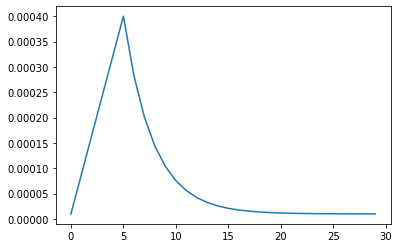

In [16]:
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .7

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## TRAIN-1 
Xception-331

In [17]:
get_filenames(IMAGE_SIZE[0][0], BATCH_SIZE, print_size=True)

Dataset: 70638 training images, 7382 unlabeled test images


In [18]:
%%time
model1 = get_xception()
Checkpoint=tf.keras.callbacks.ModelCheckpoint(f"Xception_save.h5", verbose=1, mode='max')

train_history1 = model1.fit(
    get_training_dataset(IMAGE_SIZE[0], cutmixup=True), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[lr_callback, Checkpoint])

83689472/83683744 [==============================] - 1s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
275/275 [==============================] - ETA: 0s - loss: 4.0811 - categorical_accuracy: 0.1828
Epoch 00001: saving model to Xception_save.h5
275/275 [==============================] - 158s 576ms/step - loss: 4.0811 - categorical_accuracy: 0.1828 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30
275/275 [==============================] - ETA: 0s - loss: 2.1280 - categorical_accuracy: 0.5888
Epoch 00002: saving model to Xception_save.h5
275/275 [==============================] - 160s 582ms/step - loss: 2.1280 - categorical_accuracy: 0.5888 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30
275/275 [==============================] - ETA: 0s - loss: 1.4910 - categorical_accuracy: 0.7274
Epoch 00003: saving model to Xception_save.h5
275/275 [========

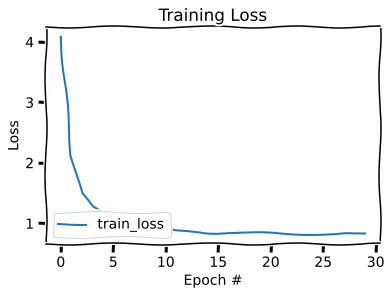

In [19]:
plot_training(train_history1)

## TRAIN-2
Densenet-224

In [20]:
get_filenames(IMAGE_SIZE[1][0], BATCH_SIZE, print_size=True)

Dataset: 70638 training images, 7382 unlabeled test images


In [21]:
%%time
model2 = get_densenet()

Checkpoint=tf.keras.callbacks.ModelCheckpoint(f"Densenet_save.h5", verbose=1, mode='max')

train_history2 = model2.fit(
    get_training_dataset(IMAGE_SIZE[1], cutmixup=True), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[lr_callback, Checkpoint],
)

51879936/51877672 [==============================] - 2s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
275/275 [==============================] - ETA: 0s - loss: 3.6578 - categorical_accuracy: 0.2492
Epoch 00001: saving model to Densenet_save.h5
275/275 [==============================] - 82s 300ms/step - loss: 3.6578 - categorical_accuracy: 0.2492 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30
275/275 [==============================] - ETA: 0s - loss: 1.9304 - categorical_accuracy: 0.6237
Epoch 00002: saving model to Densenet_save.h5
275/275 [==============================] - 82s 298ms/step - loss: 1.9304 - categorical_accuracy: 0.6237 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30
275/275 [==============================] - ETA: 0s - loss: 1.5024 - categorical_accuracy: 0.7165
Epoch 00003: saving model to Densenet_save.h5
275/275 [==========

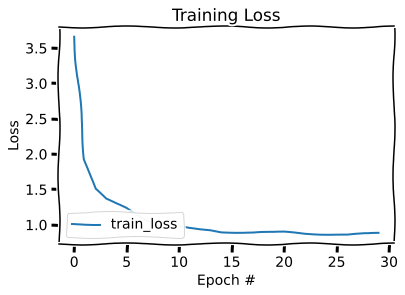

In [22]:
plot_training(train_history2)